# 1a. Achromatic joint fit

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from typing import Optional

import pandas as pd
from pytransit import BaseLPF, LinearModelBaseline, RoadRunnerModel

In [10]:
%run src/core.py
%run toi_2266.py

In [11]:
class LPF(BaseLPF):
    def __init__(self, name: str, use_ldtk: bool = False, use_opencl: bool = False, use_pdc: bool = True,
                 heavy_baseline: bool = True, downsample: Optional[float] = None, passbands=('g', 'r', 'i', 'z_s')):
        self.use_pdc = use_pdc
        self.use_opencl = use_opencl
        self.heavy_baseline = heavy_baseline
        self.downsample = downsample
        self.m2_passbands = passbands
        
        times, fluxes, pbnames, pbs, wns, covs = self.read_data()        
        pbids = pd.Categorical(pbs, categories=pbnames).codes
        wnids = arange(len(times))
        tref = floor(concatenate(times).min())
        
        tm = RoadRunnerModel('power-2-pm', small_planet_limit=0.005, parallel=True)
        super().__init__(name, "tess g r i z_s".split(), times, fluxes, pbids=pbids, wnids=wnids, 
                         covariates=covs, tm=tm, tref=tref)

    def read_data(self):
        times_t, fluxes_t, pbs_t, wns_t, ins_t, piis_t = read_tess(tess_files, zero_epoch, period,
                                                                   baseline_duration_d=0.3,
                                                                   use_pdc=self.use_pdc)
        times_m2, fluxes_m2, pbs_m2, wns_m2, covs_m2, ins_m2, piis_m2 = read_m2(m2_files,
                                                                                downsample=self.downsample,
                                                                                passbands=self.m2_passbands)
        times_l, fluxes_l, pbs_l, wns_l, covs_l, ins_l, piis_l = read_external_data()
        times_h, fluxes_h, pbs_h, wns_h, covs_h, ins_h, piis_h = read_hipercam(['data/hipercam/toi-266.01-hipercam-210805.fits'])
    
        times = times_t + times_m2 + times_l + times_h
        fluxes = fluxes_t + fluxes_m2 + fluxes_l + fluxes_h
        pbs = pbs_t + pbs_m2 + pbs_l + pbs_h
        wns = wns_t + wns_m2 + wns_l + wns_h
        if self.heavy_baseline:
            covs = len(times_t) * [array([[]])] + covs_m2 + covs_l + covs_h
        else:
            covs = (len(times_t) + len(times_m2) + len(times_l))* [array([[]])] + len(times_h)

        pbnames = 'tess g r i z_s'.split()

        self._stess = len(times_t)
        self._ntess = sum([t.size for t in times_t])
        self.ins = ins_t + ins_m2 + ins_l + ins_h
        self.piis = piis_t + piis_m2 + piis_l + piis_h

        fluxes = [f / median(f) for f in fluxes]
        covs = [(c-c.mean(0)) / c.std(0) for c in covs]

        return times, fluxes, pbnames, pbs, wns, covs

    def _post_initialisation(self):
        if self.use_opencl:
            self.tm = self.tm.to_opencl()
        self.set_prior('tc', 'NP', zero_epoch.n, zero_epoch.s)
        self.set_prior('p', 'NP', period.n, period.s)
        self.set_prior('rho', 'UP', 10, 35)
        self.set_prior('k2', 'UP', 0.0005, 0.006)

    def create_pv_population(self, npv: int = 50) -> ndarray:
        pvp = super().create_pv_population(npv)
        for p in self.ps[self._sl_lm]:
            if 'lm_i' in p.name:
                pvp[:, p.pid] = 0.01 * (pvp[:, p.pid] - 1.0) + 1.0
            else:
                pvp[:, p.pid] *= 0.01
        return pvp

    def transit_model(self, pv, copy=True):
        pv = atleast_2d(pv)
        ldc = pv[:, self._sl_ld].reshape([-1, self.npb, 2])
        zero_epoch = pv[:,0] - self._tref
        period = pv[:,1]
        smaxis = as_from_rhop(pv[:,2], period)
        inclination  = i_from_ba(pv[:,3], smaxis)
        radius_ratio = sqrt(pv[:,4:5])
        return self.tm.evaluate(radius_ratio, ldc, zero_epoch, period, smaxis, inclination)

In [20]:
lpf = LPF('toi-2266.01-joint-achromatic-p2')
lpf._add_baseline_model(LinearModelBaseline(lpf))

In [21]:
lpf.set_prior('q1_tess', 'NP', 0.78, 0.02)
lpf.set_prior('q2_tess', 'NP', 0.77, 0.02)
lpf.set_prior('q1_g', 'NP', 0.64, 0.02)
lpf.set_prior('q2_g', 'NP', 0.64, 0.02)
lpf.set_prior('q1_r', 'NP', 0.65, 0.02)
lpf.set_prior('q2_r', 'NP', 0.59, 0.02)
lpf.set_prior('q1_i', 'NP', 0.75, 0.02)
lpf.set_prior('q2_i', 'NP', 0.72, 0.02)
lpf.set_prior('q1_z_s', 'NP', 0.79, 0.02)
lpf.set_prior('q2_z_s', 'NP', 0.78, 0.02)

In [15]:
lpf.ps

[  0 |G| tc             N(μ = 2459255.6937865, σ = 0.005)        [    -inf ..      inf],
   1 |G| p              N(μ = 2.326214, σ = 0.000223)            [    0.00 ..      inf],
   2 |G| rho            U(a = 10, b = 35)                        [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0005, b = 0.006)                 [    0.00 ..      inf],
   5 |P| q1_tess        N(μ = 0.78, σ = 0.02)                    [    0.00 ..     1.00],
   6 |P| q2_tess        N(μ = 0.77, σ = 0.02)                    [    0.00 ..     1.00],
   7 |P| q1_g           N(μ = 0.64, σ = 0.02)                    [    0.00 ..     1.00],
   8 |P| q2_g           N(μ = 0.64, σ = 0.02)                    [    0.00 ..     1.00],
   9 |P| q1_r           N(μ = 0.65, σ = 0.02)                    [    0.00 ..     1.00],
  10 |P| q2_r           N(μ = 0.59, σ = 0.02)                    [    0.00 ..     1.00],
  11 |P| q1_i        

Global optimisation:   0%|          | 0/25000 [00:00<?, ?it/s]

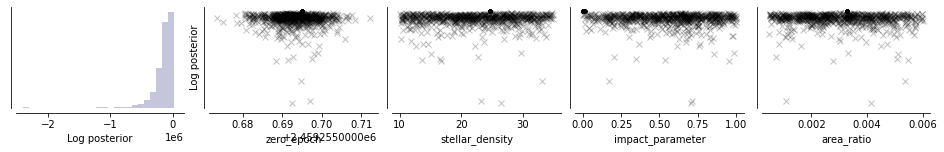

In [26]:
lpf.optimize_global(25000, npop=800)

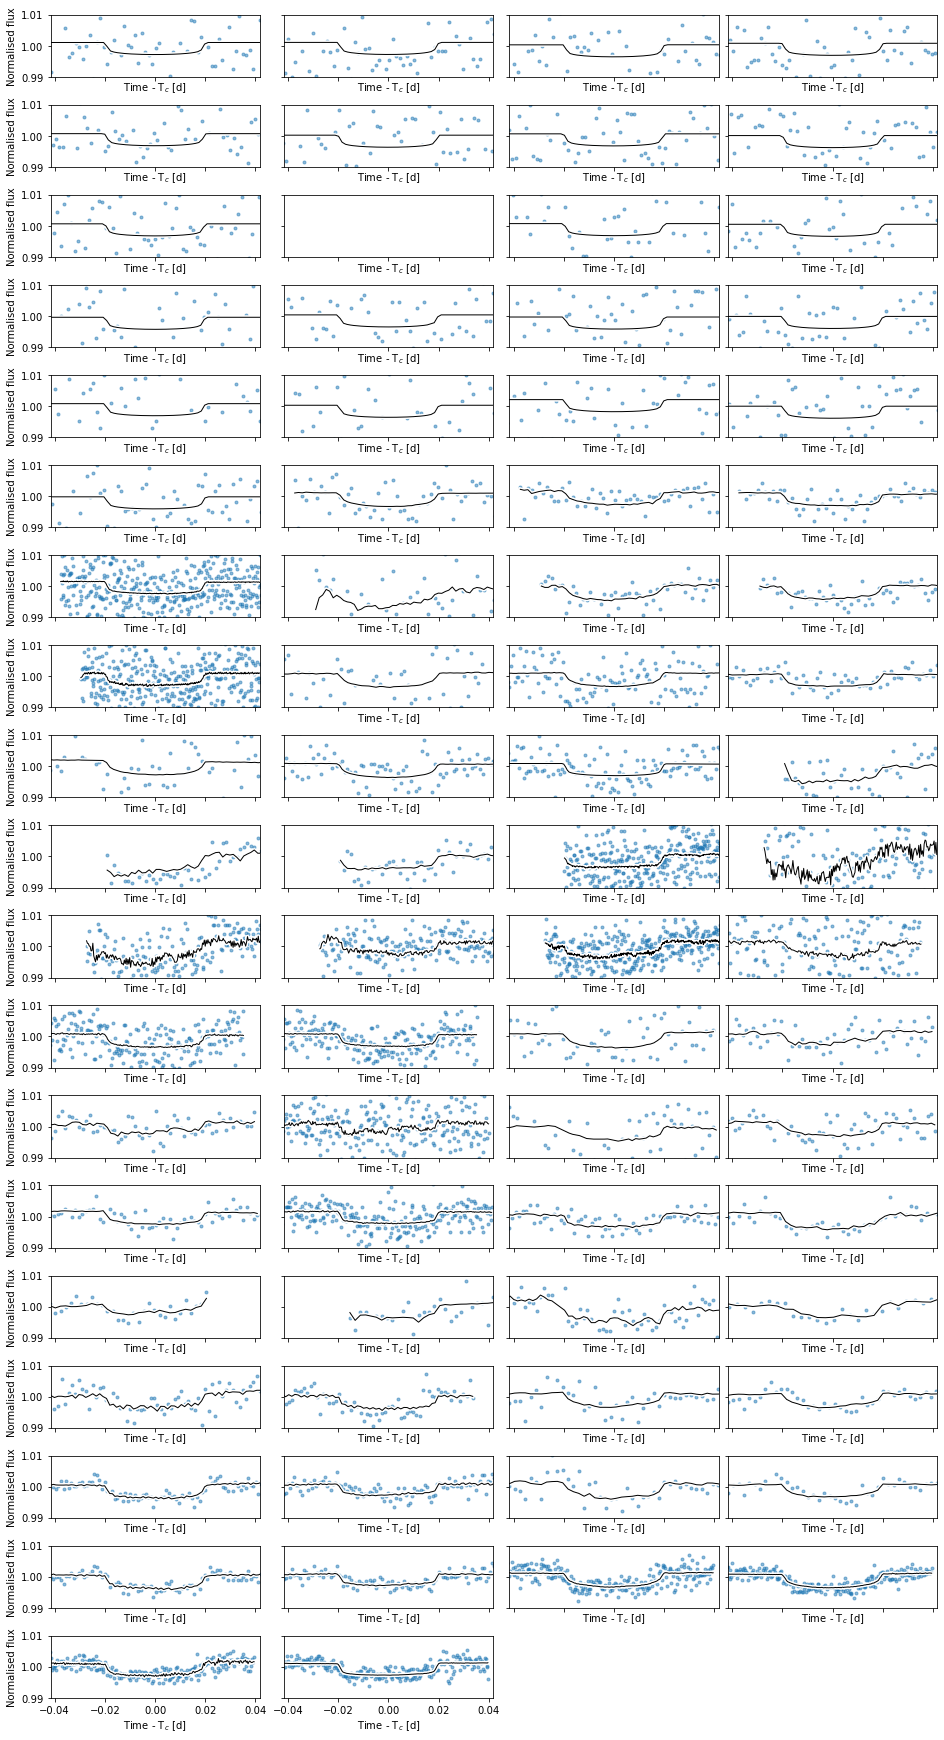

In [49]:
lpf.plot_light_curves(figsize=(13,24), ylim=(0.99, 1.01), ncol=4);

In [50]:
lpf.nlc

74

In [40]:
lpf.sample_mcmc(10000, 100, repeats=6)

MCMC sampling:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/6:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 2/6:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 3/6:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 4/6:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 5/6:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 6/6:   0%|          | 0/10000 [00:00<?, ?it/s]

In [42]:
df = lpf.posterior_samples()

In [43]:
from corner import corner

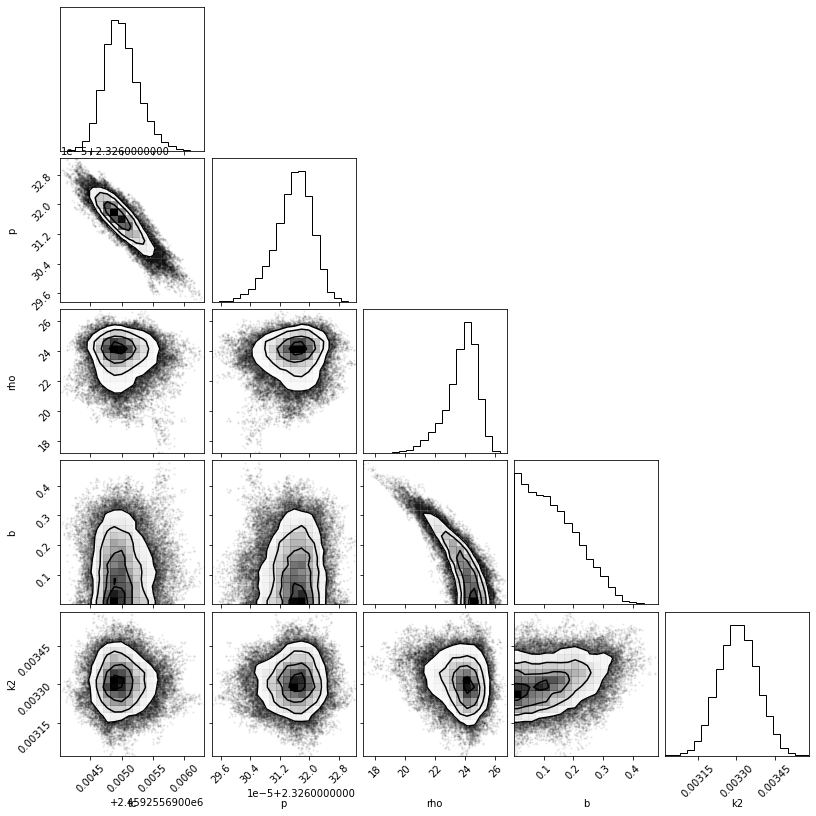

In [44]:
corner(df.iloc[:,:5].values, labels=df.columns[:5]);

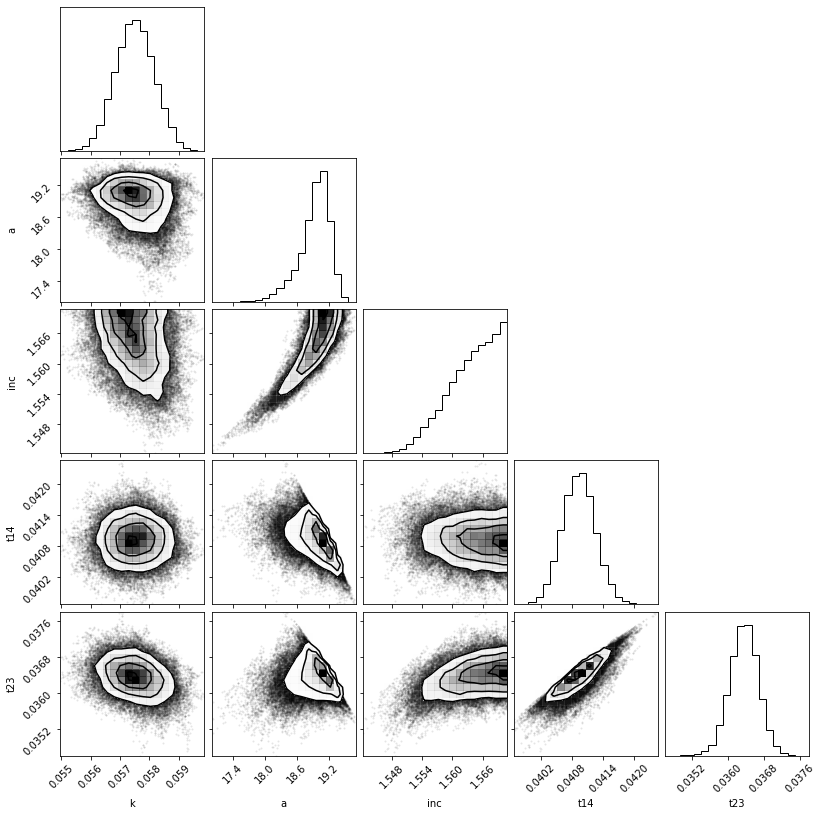

In [45]:
corner(df.iloc[:,-5:].values, labels=df.columns[-5:]);

In [46]:
lpf.save()

In [33]:
df.shape

(80000, 351)

In [47]:
rs = normal(star_r.n, star_r.s, size=df.shape[0])
rp = df.k.values * rs * (1*u.R_sun).to(u.R_earth).value

(array([1.3000e+01, 3.2800e+02, 2.5850e+03, 1.1480e+04, 2.3583e+04,
        2.5028e+04, 1.3058e+04, 3.4090e+03, 4.7600e+02, 4.0000e+01]),
 array([1.34668574, 1.40271297, 1.45874019, 1.51476742, 1.57079465,
        1.62682187, 1.6828491 , 1.73887633, 1.79490356, 1.85093078,
        1.90695801]),
 <BarContainer object of 10 artists>)

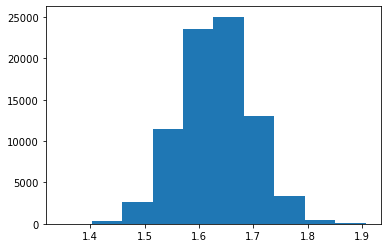

In [48]:
hist(rp)

In [36]:
from pytransit.utils.eclipses import Teq

In [37]:
ns = df.shape[0]

In [38]:
teq = Teq(normal(star_teff.n, star_teff.s, size=ns), df.a, uniform(0.25, 0.50, ns), uniform(0, 0.9, ns))

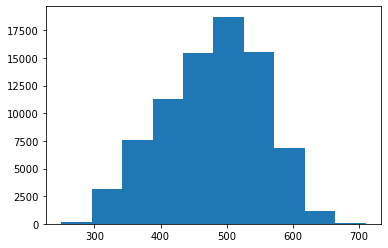

In [39]:
hist(teq);